# Can we predict who would've survived the Titanic?

### This notebook goes through a basic exploratory data analysis of the Kaggle Titanic dataset with Python


## Step 0: Why EDA?


Not all data comes in a neat little package ready to be modelled by the latest and greatest machine learning models. Most of the time, you'll get a dataset you don't know much about. So before you can make any solid predictions, you'll to find out more.

This is where EDA comes in.

The main thing to remember is the first word. Exploratory. You're trying to figure out more about the data so you can build a model the best way you can.

You'll usually do this when you first look at a dataset but it'll continually happen as you learn more. EDA is an iterative process. There's no one way to do it either. It'll vary with each new dataset but there are some things you'll find yourself doing more often, we'll talk about those in this notebook and in a future blog post.


## Step 1: Download the data

You can download the data for this notebook here: https://www.kaggle.com/c/titanic/data

## Data Descriptions

**Survival:** 0 = No, 1 = Yes

**pclass (Ticket class):** 1 = 1st, 2 = 2nd, 3 = 3rd

**sex:** Sex

**Age:** Age in years

**sibsp:** number of siblings/spouses aboard the Titanic

**parch:** number of parents/children aboard the Titanic

**ticket:** Ticket number

**fare:** Passenger fare

**cabin:** Cabin number

**embarked:** Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

## Step 2: Import the required libraries


In [1]:
# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt

# Import Dependencies
%matplotlib inline

#import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
# import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
# from catboost import CatBoostClassifier, Pool, cv

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [9]:
from sklearn.compose import make_column_transformer

## Step 3: Loading in the data
Load "train.csv", "test.csv", "gender_submission.csv" into 3 variables as data frame

In [2]:
# Import train & test data 
train_org = pd.read_csv('data/train.csv')
test_org = pd.read_csv('data/test.csv')
test_org_gender_submission = pd.read_csv('data/gender_submission.csv') # example of what a submission should look like

In [3]:
# Identifying Number of Rows and Columns in "train_org", "test_org" and "test_org_gender_submission"
print('\"train_org\" details :')
print("Shape \t: ", train_org.shape)
print("Rows \t: ", train_org.shape[0])
print("Column \t: ", train_org.shape[1])

print('====================================')

print('\"test_org\" details :')
print("Shape \t: ", test_org.shape)
print("Rows \t: ", test_org.shape[0])
print("Column \t: ", test_org.shape[1])

print('====================================')

print('\"test_org_gender_submission\" details :')
print("Shape \t: ", test_org_gender_submission.shape)
print("Rows \t: ", test_org_gender_submission.shape[0])
print("Column \t: ", test_org_gender_submission.shape[1])


"train_org" details :
Shape 	:  (891, 12)
Rows 	:  891
Column 	:  12
"test_org" details :
Shape 	:  (418, 11)
Rows 	:  418
Column 	:  11
"test_org_gender_submission" details :
Shape 	:  (418, 2)
Rows 	:  418
Column 	:  2


## Step 4: EDA

##### 4.1) Copy "train_org" into "df_train" with required columns
Ignore the columns which won't effect the "Survived" column
Ignore columns are:
1. "PassengerId" : It is unique id number given to passanger and it won't tell the possibility of the passanger is Survived. But still I will keep this column for refernece to extract the required data.
2. "Name": Based on the name we can not decide the passanger is Survived or not. Eventhough the name tells us whether the passanger is male or female by "Mr.", "Mrs.", "Miss.", we ignore this because of this information is available in Sex column.
3. "Ticket": It tells us the passanger is beloning to which "Class", "Cabin" and "Seat", but this information is available in "Pclass", "Cabin", "Embarked" columns.
4. "Fare": It tells only the amount the passanger paid to travel. This won't effect the target column.

In [4]:
# 1) Copy "train_org" into "df_train"
df_train = train_org.drop(columns=['Name', 'Ticket', 'Fare'])

##### 4.2) Identifying Number of Rows and Columns in "df_train"

In [5]:
# 2) Identifying Number of Rows and Columns in "df_train"
print('\"df_train\" details :')
print("Shape \t: ", df_train.shape)
print("Rows \t: ", df_train.shape[0])
print("Column \t: ", df_train.shape[1])

"df_train" details :
Shape 	:  (891, 9)
Rows 	:  891
Column 	:  9


##### 4.3) Identifying Missing Values in each Column

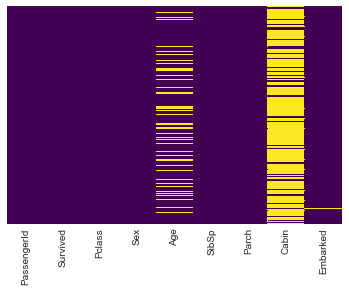

In [6]:
sns.heatmap(df_train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Cabin        204 non-null    object 
 8   Embarked     889 non-null    object 
dtypes: float64(1), int64(5), object(3)
memory usage: 62.8+ KB


In [8]:
print("Missing values are :")
print('Age \t : ', df_train.Age.isnull().sum())
print('Cabin \t : ', df_train.Cabin.isnull().sum())
print('Embarked : ', df_train.Embarked.isnull().sum())

Missing values are :
Age 	 :  177
Cabin 	 :  687
Embarked :  2


##### 4.4) Replacing Missing values

##### 4.4.1) Replacinng "Embarked" column

In [10]:
df_train[df_train.Embarked.isnull()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked
61,62,1,1,female,38.0,0,0,B28,NaN
829,830,1,1,female,62.0,0,0,B28,NaN


In [15]:
df_train.loc[
    (df_train.Pclass==1) &
    (df_train.Sex=='female') &
    (df_train.Age>37) & (df_train.Age<63) &
    (df_train.SibSp==0) &
    (df_train.Parch==0)]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked
11,12,1,1,female,58.0,0,0,C103,S
61,62,1,1,female,38.0,0,0,B28,NaN
177,178,0,1,female,50.0,0,0,C49,C
194,195,1,1,female,44.0,0,0,B4,C
195,196,1,1,female,58.0,0,0,B80,C
337,338,1,1,female,41.0,0,0,E40,C
380,381,1,1,female,42.0,0,0,NaN,C
609,610,1,1,female,40.0,0,0,C125,S
716,717,1,1,female,38.0,0,0,C45,C
796,797,1,1,female,49.0,0,0,D17,S


*Observation:*  
By observing the above result we can repalce two missing values by 'C'

In [16]:
df_train.loc[61,'Embarked']='C'
df_train.loc[829,'Embarked']='C'

In [17]:
print("Missing values in Embarked column is : ", df_train.Embarked.isnull().sum())

Missing values in Embarked column is :  0


##### 4.4.2) Replacinng "Cabin" column

In [18]:
df_train[df_train.Cabin.isnull()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked
0,1,0,3,male,22.0,1,0,NaN,S
2,3,1,3,female,26.0,0,0,NaN,S
4,5,0,3,male,35.0,0,0,NaN,S
5,6,0,3,male,NaN,0,0,NaN,Q
7,8,0,3,male,2.0,3,1,NaN,S
...,...,...,...,...,...,...,...,...,...
884,885,0,3,male,25.0,0,0,NaN,S
885,886,0,3,female,39.0,0,5,NaN,Q
886,887,0,2,male,27.0,0,0,NaN,S
888,889,0,3,female,NaN,1,2,NaN,S


*Observation:*  
It has so many missing values and we can not make use for the target values. In this case, we just simply drop the entire column.

In [19]:
# Droping the "Cabin" column
df_train.drop('Cabin', axis=1, inplace=True)

##### 4.4.3) Replacinng "Age" column

*Note:*  
I hope Age values might depend on "Pclass", "Sex", "Emabarked", so I try to replace null values with average Age values to corresponding "Pclass", "Sex", "Emabarked".

In [20]:
print("List of unique values in \'Pclass\', \'Sex\', \'Embarked\'\n")
print("Pclass values \t:", list(df_train.Pclass.unique()))
print("Sex values \t:", list(df_train.Sex.unique()))
print("Embarked values :", list(df_train.Embarked.unique()))

List of unique values in 'Pclass', 'Sex', 'Embarked'

Pclass values 	: [3, 1, 2]
Sex values 	: ['male', 'female']
Embarked values : ['S', 'C', 'Q']


In [30]:
# Extracting the data from df_train in which Age column values are not null
df_train_notnull = df_train[df_train.Age.notnull()]

# Extracting the data from df_train in which Age column values are null
df_train_null = df_train[df_train.Age.isnull()]

In [240]:
# Creating a function to find and replace the mean of Age values based on "Pclass", "Embarked" and "Sex"
def replace_age(Pclass, Sex, Embarked):
    
    # Storing conditions based on Pclass, Sex, Embarked
    R1 = (df_train_notnull.Pclass==Pclass)
    R2 = (df_train_notnull.Sex==Sex)
    R3 = (df_train_notnull.Embarked==Embarked)
    
    # Generating a Rule based on R1, R2, and R3
    Rule = pd.Series(np.full(df_test_notnull.shape[0],1))
    if R1.sum()>0:
        Rule = Rule & R1
        if R2.sum()>0:
            Rule = Rule & R2
            if R3.sum()>0:
                Rule = Rule & R3
        elif R3.sum()>0:
            Rule = Rule & R3
    elif R2.sum()>0:
        Rule = Rule & R2
        if R3.sum()>0:
            Rule = Rule & R3
    elif R3.sum()>0:
        Rule = Rule & R3
    else:
        return
    
    # Finding mean of the age column based on Pclass, Sex, and Embarked
    age_mean = round(df_train_notnull[Rule].Age.mean())
    print('Mean of Pclass:{}, Sex:{}, Embarked:{} is {}'.format(Pclass, Sex, Embarked, age_mean))
    
    # Replacing "Age null values" with "Age mean values" based on Pclass, Sex, and Embarked
    for index, row in df_train.iterrows():
        if (np.isnan(row['Age'])) & (row['Pclass']==Pclass) & (row['Sex']==Sex) & (row['Embarked']==Embarked):
            df_train.loc[index, 'Age'] = age_mean

In [34]:
# Run the "replace_age()" function
for Pclass in list(df_train.Pclass.unique()):
    for Sex in list(df_train.Sex.unique()):
        for Embarked in list(df_train.Embarked.unique()):
            if bool(((df_train_null.Pclass==Pclass) & (df_train_null.Sex==Sex) & (df_train_null.Embarked==Embarked)).sum()):
                # Run the function when the above Condition is true only
                replace_age(Pclass, Sex, Embarked)

Mean of Pclass:3, Sex:male, Embarked:S is 27
Mean of Pclass:3, Sex:male, Embarked:C is 25
Mean of Pclass:3, Sex:male, Embarked:Q is 28
Mean of Pclass:3, Sex:female, Embarked:S is 23
Mean of Pclass:3, Sex:female, Embarked:C is 14
Mean of Pclass:3, Sex:female, Embarked:Q is 23
Mean of Pclass:1, Sex:male, Embarked:S is 42
Mean of Pclass:1, Sex:male, Embarked:C is 40
Mean of Pclass:1, Sex:male, Embarked:Q is 44
Mean of Pclass:1, Sex:female, Embarked:S is 33
Mean of Pclass:1, Sex:female, Embarked:C is 37
Mean of Pclass:1, Sex:female, Embarked:Q is 33
Mean of Pclass:2, Sex:male, Embarked:S is 31
Mean of Pclass:2, Sex:male, Embarked:C is 26
Mean of Pclass:2, Sex:male, Embarked:Q is 57
Mean of Pclass:2, Sex:female, Embarked:S is 30
Mean of Pclass:2, Sex:female, Embarked:C is 19
Mean of Pclass:2, Sex:female, Embarked:Q is 30


In [35]:
df_train.Age.isnull().sum()

0

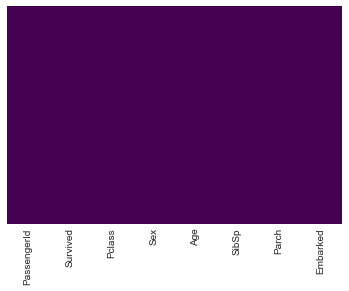

In [36]:
# Cross checking the null values in the columns of data frame by Visualizing 
sns.heatmap(df_train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Embarked     891 non-null    object 
dtypes: float64(1), int64(5), object(2)
memory usage: 55.8+ KB


*Observation:*  
Observe that no column values are null.

##### 4.4.4) Visualizing the survived passangers

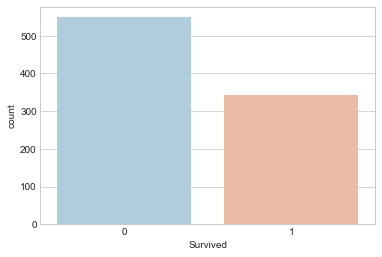

In [38]:
# Number of survived passengers
sns.countplot(x='Survived', data=df_train, palette='RdBu_r')

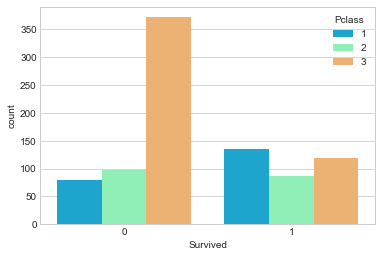

In [39]:
# Number of survived passengers in "PClass"
sns.countplot(x='Survived', hue='Pclass', data=df_train, palette='rainbow')

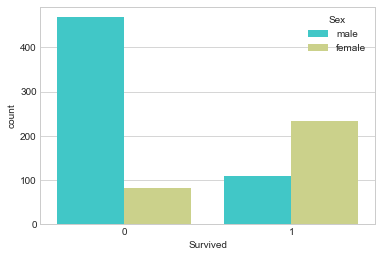

In [40]:
# Number of survived passengers in "Sex"
sns.countplot(x='Survived', hue='Sex', data=df_train, palette='rainbow')

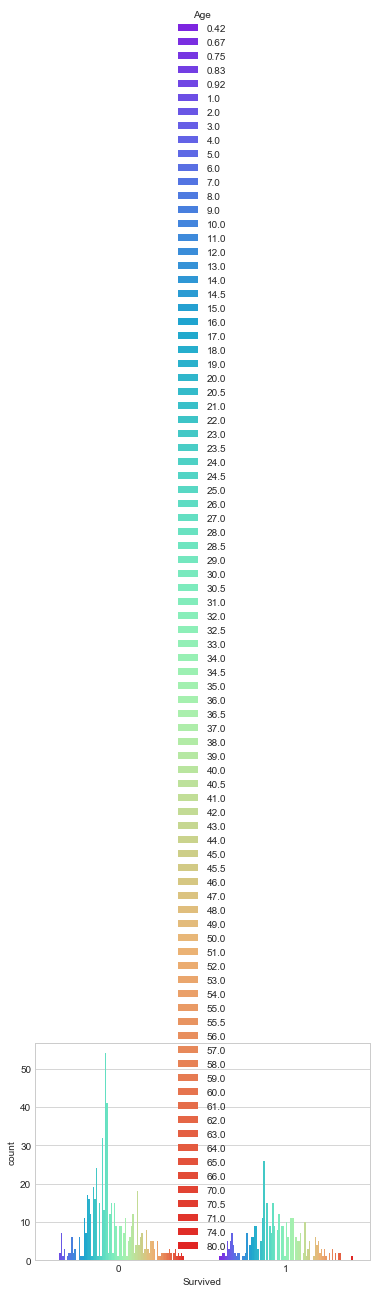

In [41]:
# Number of survived passengers in "Age"
sns.countplot(x='Survived', hue='Age', data=df_train, palette='rainbow')

In [ ]:
# Counting number of passengers "Age" column wise using bins
sns.distplot(df_train['Age'].dropna(), kde=False, color='darkred', bins=40)

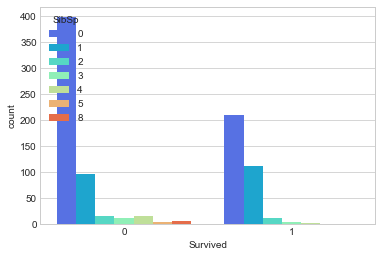

In [42]:
# Number of survived passengers in "SibSp"
sns.countplot(x='Survived', hue='SibSp', data=df_train, palette='rainbow')

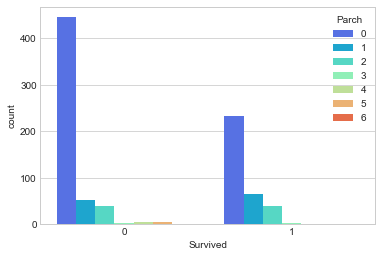

In [43]:
# Number of survived passengers in "Parch"
sns.countplot(x='Survived', hue='Parch', data=df_train, palette='rainbow')

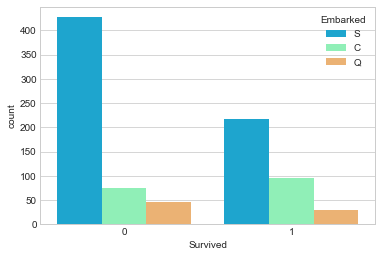

In [44]:
# Number of survived passengers in "Embarked"
sns.countplot(x='Survived', hue='Embarked', data=df_train, palette='rainbow')

##### 4.4.5) Identifying Numerical columns and Categorical Columns and Seperate them

##### Observations:
###### Numerical Columns:  
    1. PassengerId
    2. Survived
    3. Age
    4. SibSp
    5. Parch
###### Categorical Columns:
    1. Pclass
    2. Sex
    3. Cabin
    4. Embarked

In [45]:
df_train_numericals = df_train[['PassengerId', 'Survived', 'Age', 'SibSp', 'Parch']]
df_train_categoricals = df_train[['Pclass', 'Sex', 'Embarked']]

##### 4.4.6) Converting categorical values to numerical values by lable encoading

In [46]:
# Using OneHotEncoder(), we transform 'Sex' and 'Embarked' columns into numerical columns.
OHE = OneHotEncoder(sparse=False, drop='first')
df_train_categoricals_array = OHE.fit_transform(df_train_categoricals[['Sex', 'Embarked']])
df_train_categoricals_OHE = pd.DataFrame(df_train_categoricals_array, columns=['Sex_Male', 'Embarked_Q', 'Embarked_S'] )

# Alternative way
# column_trans = make_column_transformer((OneHotEncoder(), ['Sex', 'Embarked']), remainder='passthrough')

In [52]:
df_train_categoricals_OHE

,Sex_Male,Embarked_Q,Embarked_S
0,1.0,0.0,1.0
1,0.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,1.0,0.0,1.0
...,...,...,...
886,1.0,0.0,1.0
887,0.0,0.0,1.0
888,0.0,0.0,1.0
889,1.0,0.0,0.0


In [48]:
OHE.categories_

[array(['female', 'male'], dtype=object), array(['C', 'Q', 'S'], dtype=object)]

##### 4.4.7) Combining "df_train_numericals" and "df_train_categoricals" into "df_train"

In [56]:
# Combining numerical columns and transformed categorical columns into "df_train_OHE"
df_train_OHE = pd.concat([df_train_numericals, df_train_categoricals_OHE], axis=1)

##### 4.4.8) Preparing Training data and Test data to train the model

In [59]:
# Preparing X(Input) and Y(Output) to train the model
X = df_train_OHE[['Age', 'SibSp', 'Parch', 'Sex_Male', 'Embarked_Q', 'Embarked_S']]
Y = df_train_OHE[['Survived']]

In [60]:
# Splitting the Training data and Testing data to train the model and test the model
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

## Step 5: Training Model

##### 1) Logistic Regression

In [65]:
# Training the model using LogisticRegression()
LR = LogisticRegression(solver='lbfgs')
LR.fit(X_train, Y_train)
LR.predict(X_test)
LR_Score = LR.score(X_test, Y_test)
print(LR_Score)

0.7877094972067039


## Step 6: Predicting the outcomes of given test data

##### 6.1) EDA - Copy "test_org" into "df_test" with required columns

In [72]:
# Copying "test_org" into "df_test" by droping columns "Name", "Ticket" and "Fare"
df_test = test_org.drop(columns=['Name', 'Ticket', 'Fare'])
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked
0,892,3,male,34.5,0,0,NaN,Q
1,893,3,female,47.0,1,0,NaN,S
2,894,2,male,62.0,0,0,NaN,Q
3,895,3,male,27.0,0,0,NaN,S
4,896,3,female,22.0,1,1,NaN,S


##### 6.2) EDA - Identifying Number of Rows and Columns in "df_test"

In [74]:
# 2) Identifying Number of Rows and Columns in "df_train"
print('\"df_test\" details :')
print("Shape \t: ", df_test.shape)
print("Rows \t: ", df_test.shape[0])
print("Column \t: ", df_test.shape[1])

"df_test" details :
Shape 	:  (418, 8)
Rows 	:  418
Column 	:  8


##### 6.3) EDA - Identifying Missing Values in each Column

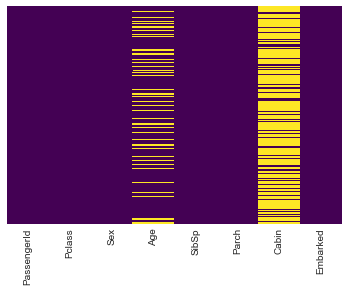

In [75]:
sns.heatmap(df_test.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [77]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    object 
 3   Age          332 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Cabin        91 non-null     object 
 7   Embarked     418 non-null    object 
dtypes: float64(1), int64(4), object(3)
memory usage: 26.2+ KB


*Observation:*  
By observing the above results, we could understand that "Age" and "Cabin" columns are having null values.

In [78]:
print("Missing values are :")
print('Age \t : ', df_test.Age.isnull().sum())
print('Cabin \t : ', df_test.Cabin.isnull().sum())

Missing values are :
Age 	 :  86
Cabin 	 :  327


##### 6.4) EDA - Replacing Missing values

##### 6.4.1) Replacinng "Cabin" column

As we have droped "Cabin" column in df_test data, here also we drop the "Cabin" column.

In [79]:
# Droping the "Cabin" column since it has more null values
df_test.drop('Cabin', axis=1, inplace=True)

##### 6.4.2) Replacinng "Age" column


We do the same as we have done for df_train data frame.

In [80]:
print("List of unique values in \'Pclass\', \'Sex\', \'Embarked\'\n")
print("Pclass values \t:", list(df_test.Pclass.unique()))
print("Sex values \t:", list(df_test.Sex.unique()))
print("Embarked values :", list(df_test.Embarked.unique()))

List of unique values in 'Pclass', 'Sex', 'Embarked'

Pclass values 	: [3, 2, 1]
Sex values 	: ['male', 'female']
Embarked values : ['Q', 'S', 'C']


In [81]:
# Extracting the data from df_test in which Age column values are not null
df_test_notnull = df_test[df_test.Age.notnull()]

# Extracting the data from df_test in which Age column values are null
df_test_null = df_test[df_test.Age.isnull()]

In [233]:
# Creating a function to find and replace the mean of Age values based on "Pclass", "Embarked" and "Sex"
def replace_test_age(Pclass, Sex, Embarked):
    
    # Storing conditions based on Pclass, Sex, Embarked
    R1 = (df_test_notnull.Pclass==Pclass)
    R2 = (df_test_notnull.Sex==Sex)
    R3 = (df_test_notnull.Embarked==Embarked)
    
    # Generating a Rule based on R1, R2, and R3
    Rule = pd.Series(np.full(df_test_notnull.shape[0],1))
    if R1.sum()>0:
        Rule = Rule & R1
        if R2.sum()>0:
            Rule = Rule & R2
            if R3.sum()>0:
                Rule = Rule & R3
        elif R3.sum()>0:
            Rule = Rule & R3
    elif R2.sum()>0:
        Rule = Rule & R2
        if R3.sum()>0:
            Rule = Rule & R3
    elif R3.sum()>0:
        Rule = Rule & R3
    else:
        return
    
    # Finding mean of the age column based on Pclass, Sex, and Embarked
    age_mean = round(df_test_notnull[Rule].Age.mean())
    print('Mean of Pclass:{}, Sex:{}, Embarked:{} is {}'.format(Pclass, Sex, Embarked, age_mean))
    
    # Replacing "Age null values" with "Age mean values" based on Pclass, Sex, and Embarked
    for index, row in df_test.iterrows():
        if (np.isnan(row['Age'])) & (row['Pclass']==Pclass) & (row['Sex']==Sex) & (row['Embarked']==Embarked):
            df_test.loc[index, 'Age'] = age_mean

In [238]:
# Run the "replace_age()" function
for Pclass in list(df_test.Pclass.unique()):
    for Sex in list(df_test.Sex.unique()):
        for Embarked in list(df_test.Embarked.unique()):
            if bool(((df_test_null.Pclass==Pclass) & (df_test_null.Sex==Sex) & (df_test_null.Embarked==Embarked)).sum()):
                # Run the function when the above Condition is true only
                replace_test_age(Pclass, Sex, Embarked)

Mean of Pclass:2, Sex:female, Embarked:S is 25
Mean of Pclass:1, Sex:male, Embarked:S is 43
Mean of Pclass:1, Sex:male, Embarked:C is 39
Mean of Pclass:1, Sex:female, Embarked:C is 42


##### 6.4.3) Identifying Numerical columns and Categorical Columns and Seperate them

In [243]:
df_test_numericals = df_test[['PassengerId', 'Age', 'SibSp', 'Parch']]
df_test_categoricals = df_test[['Pclass', 'Sex', 'Embarked']]

##### 6.4.4) Converting categorical values to numerical values by lable encoading

In [244]:
# Using OneHotEncoder(), we transform 'Sex' and 'Embarked' columns into numerical columns.
OHE = OneHotEncoder(sparse=False, drop='first')
df_test_categoricals_array = OHE.fit_transform(df_test_categoricals[['Sex', 'Embarked']])
df_test_categoricals_OHE = pd.DataFrame(df_test_categoricals_array, columns=['Sex_Male', 'Embarked_Q', 'Embarked_S'] )

##### 6.4.5) Combining "df_train_numericals" and "df_train_categoricals" into "df_train"

In [ ]:
# Combining numerical columns and transformed categorical columns into "df_train_OHE"
df_test_OHE = pd.concat([df_test_numericals, df_test_categoricals_OHE], axis=1)

##### 6.4.6) Preparing Training data and Test data to train the model`

In [258]:
# Preparing X(Input) and Y(Output) to train the model
X = df_test_OHE[['Age', 'SibSp', 'Parch', 'Sex_Male', 'Embarked_Q', 'Embarked_S']]

In [260]:
df_test_pred = LR.predict(X)

In [268]:
LR_Score = LR.score(X, test_org_gender_submission['Survived'])

In [269]:
print(LR_Score)

0.992822966507177


In [278]:
# Storing prediction values into test dataframe
df_test_OHE['Survived'] = df_test_pred

In [280]:
# Exporting columns "PassengerId", "Prediction Survived" into csv file
df_test_OHE[['PassengerId', 'Survived']].to_csv('test_results.csv')

In [282]:
# Storing actual submission values into test_results dataframe
df_test_results = df_test_OHE[['PassengerId', 'Survived']]
df_test_results['Survived_Submission'] = test_org_gender_submission['Survived']

# Exporting columns "PassengerId", "Prediction Survived"  and "Actual Survived" into csv file
df_test_results.to_csv('test_results_compare.csv')

In [286]:
df_test_results[df_test_results['Survived']!=df_test_results['Survived_Submission']]

,PassengerId,Survived,Survived_Submission
140,1032,0,1
188,1080,0,1
214,1106,0,1


##### ================================================================================================

## Task: 
##### Add extra column in data frame as 'Name_Dummy' which contains numerical values like below
0 : [Mr., Mr , Master]  
1 : [Miss.]  
2 : [Mrs., Mrs , Ms]  
3 : [Dr.]  
4 : [Rev.]  
5 : [Others]  


In [288]:
# Loading Data into "df_train_1"
df_train_1 = pd.read_csv('data/train.csv')

In [289]:
# How many different names are there?
df_train_1.Name.value_counts()

Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)    1
Jensen, Mr. Hans Peder                               1
Flynn, Mr. James                                     1
Farrell, Mr. James                                   1
Hirvonen, Miss. Hildur E                             1
                                                    ..
Ali, Mr. William                                     1
Markun, Mr. Johann                                   1
Murphy, Miss. Margaret Jane                          1
Webber, Miss. Susan                                  1
Harrison, Mr. William                                1
Name: Name, Length: 891, dtype: int64

In [290]:
# Labeling Name column values
Name_Dummy = []
for name in df_train_1['Name']:
    if ('Mr.' in name) or ('Master' in name) or ('Mr ' in name):
        Name_Dummy.append(0)
    elif 'Miss.' in name:
        Name_Dummy.append(1)
    elif ('Mrs.' in name) or ('Mrs ' in name) or ('Ms.' in name):
        Name_Dummy.append(2)
    elif ('Dr.' in name):
        Name_Dummy.append(3)
    elif ('Rev.' in name):
        Name_Dummy.append(4)
    else:
        Name_Dummy.append(5)
print("Given lables for name column\n0 : [Mr., Mr , Master]\n1 : [Miss.]\n2 : [Mrs., Mrs , Ms]\n3 : [Dr.]\n4 : [Rev.]\n5 : [Others]")
df_train_1['Name_Dummy'] = pd.Series(Name_Dummy)

Given lables for name column
0 : [Mr., Mr , Master]
1 : [Miss.]
2 : [Mrs., Mrs , Ms]
3 : [Dr.]
4 : [Rev.]
5 : [Others]


In [293]:
df_train_1[['Name', 'Name_Dummy']]

,Name,Name_Dummy
0,"Braund, Mr. Owen Harris",0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2
2,"Heikkinen, Miss. Laina",1
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2
4,"Allen, Mr. William Henry",0
...,...,...
886,"Montvila, Rev. Juozas",4
887,"Graham, Miss. Margaret Edith",1
888,"Johnston, Miss. Catherine Helen ""Carrie""",1
889,"Behr, Mr. Karl Howell",0


##### ===================================================== END =====================================================